# Imports

In [8]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
pd.set_option('float_format', '{:f}'.format)
pd.set_option('display.max_rows', 30)
pd.set_option('display.max_columns', 99)
import pandas_bokeh
pandas_bokeh.output_file("data/bokeh_output.html")
from qgrid import show_grid
# import finplot as fplt

import polygon_rest_api as papi
import polygon_ws_api as pws
import polygon_df as pdf
import polygon_ds as pds
import polygon_s3 as ps3
import polygon_backfill_flow as fb

import bar_samples as bs
import bar_labels as bl
import bar_workflow_ray as bm

import utils_filters as ft

import matplotlib as mpl
from matplotlib import style
style.use('fivethirtyeight')
mpl.rcParams['figure.figsize'] = [20, 7]

# import ipdb
# ipdb.set_trace(context=10)

# df.style.background_gradient(cmap='coolwarm', axis=None, vmin=-1, vmax=1)  # 'Blues', 'coolwarm', 'RdBu_r' & 'BrBG' are other good diverging colormaps
# pd.set_option('precision', 2)

# .plot_bokeh(sizing_mode="scale_height")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Backfill Data

In [ ]:
clust_gold = ['AEM', 'AGI', 'ASA', 'AU', 'AUY', 'BTG', 'DRD', 'EGO', 'FNV', 'GFI', 'HMY', 'IAG', 'KGC', 'KL', 'NEM', 'NG', 'OR', 'PAAS', 'RGLD', 'SA', 'SAND', 'SSRM', 'WPM']

clust_silver = ['AG', 'AXU', 'BVN', 'CDE', 'EXK', 'FSM', 'GORO', 'GSS', 'HL', 'MAG', 'MUX', 'PVG', 'SVM', 'USAS']

all_sym = clust_gold + clust_silver + ['VTI', 'GLD']

In [189]:
# check existing data

pd.Series(ps3.list_symbol_dates(symbol='VTI', tick_type='trades'))

0      2019-01-02
1      2019-01-03
2      2019-01-04
3      2019-01-07
4      2019-01-08
          ...    
496    2020-12-18
497    2020-12-21
498    2020-12-22
499    2020-12-23
500    2020-12-24
Length: 501, dtype: object

In [ ]:
# backfill market daily

fb.run_flow(
    symbols=['market'],
    tick_type='daily',
    start_date='2016-01-01',
    n_workers=4,
    threads_per_worker=8
)

In [ ]:
# backfill trades

fb.run_flow(
    symbols=all_sym,
    tick_type='trades', 
    start_date='2019-01-01', 
    n_workers=2, 
    threads_per_worker=4
)

# Sample Ticks

In [261]:
symbol = 'VTI'
start_date = '2020-11-01'
end_date = '2020-11-31'
date = '2020-11-18'

ticks_df = ps3.fetch_date_df(symbol, date, tick_type='trades')
daily_df = bm.get_symbol_vol_filter(symbol, start_date, end_date)

VTI 2020-11-18 trying to get data from local file...


In [267]:
# set sampling params

range_est = daily_df[daily_df.date == date]['range_jma_lag'].values[0]

pct_value_min = daily_df[daily_df.date == date].vwap_jma_lag.values[0] * 0.0005

renko_size = max(range_est / 20, pct_value_min)
print('renko size:', renko_size)

thresh = {
    # max thresholds
    'renko_size': renko_size,
    'renko_return': 'jma_return',
    'renko_reveral_multiple': 2,
    'max_duration_sec': 60*60*1/2,
    # min thresholds
    'min_duration_sec': 10,
    'min_tick_count': 30,
}

ticks_df = ticks_df.set_index('sip_dt').between_time('14:30:00', '21:00:00').reset_index()

renko size: 0.11108632527322895


In [268]:
# sample bars
bars, ticks_filtered = bs.build_bars(ticks_df, thresh)

bars_df = pd.DataFrame(bars)

ticks2_df = pd.DataFrame(ticks_filtered)

ticks2_df.status.value_counts() / ticks2_df.shape[0]

clean                 0.993074
irregular_condition   0.004550
timestamps_delta      0.002118
outlier_filter        0.000258
Name: status, dtype: float64

In [269]:
bars_df.bar_trigger.value_counts() / bars_df.shape[0]

renko_down   0.653846
renko_up     0.288462
duration     0.057692
Name: bar_trigger, dtype: float64

<AxesSubplot:xlabel='date_time'>

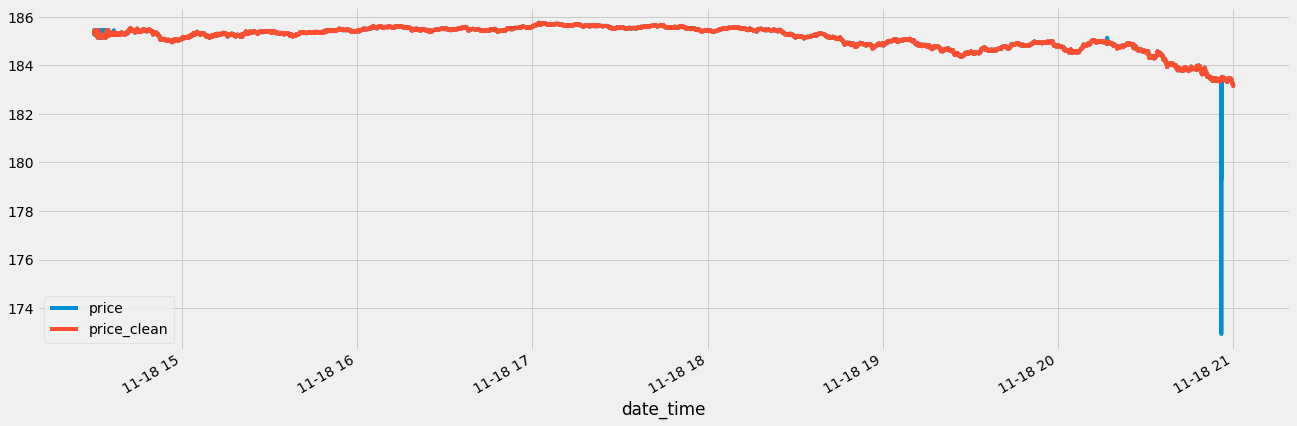

In [270]:
ticks2_df['price_clean'] = ticks2_df.price

ticks2_df.loc[ticks2_df.status!='clean', 'price_clean'] = None

ticks2_df.set_index('date_time')[['price', 'price_clean']].plot()

<AxesSubplot:xlabel='date_time'>

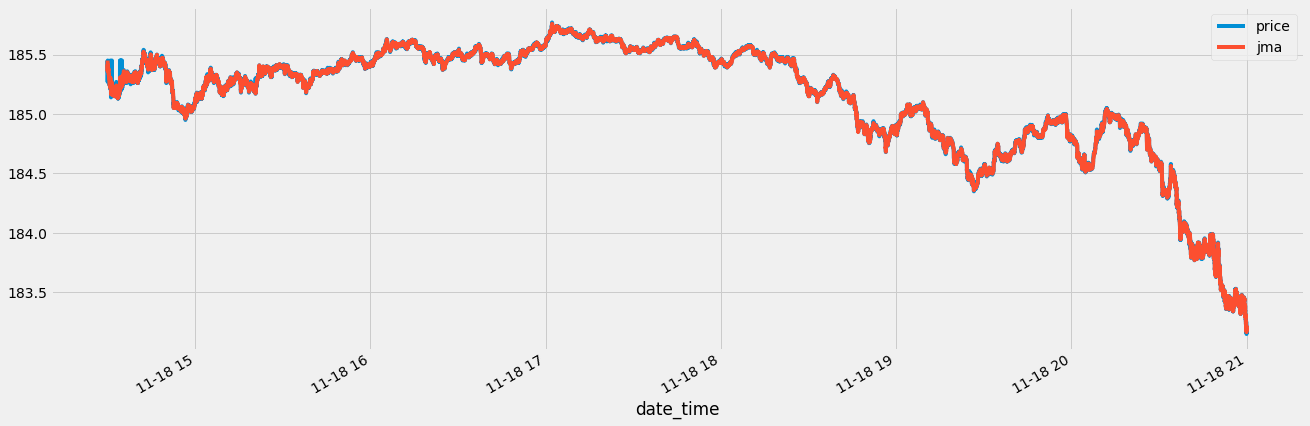

In [271]:
# ticks2_df[ticks2_df.status=='clean'][['jma']].plot()
ticks2_df[ticks2_df.status=='clean'].set_index('date_time')[['price', 'jma']].plot()

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

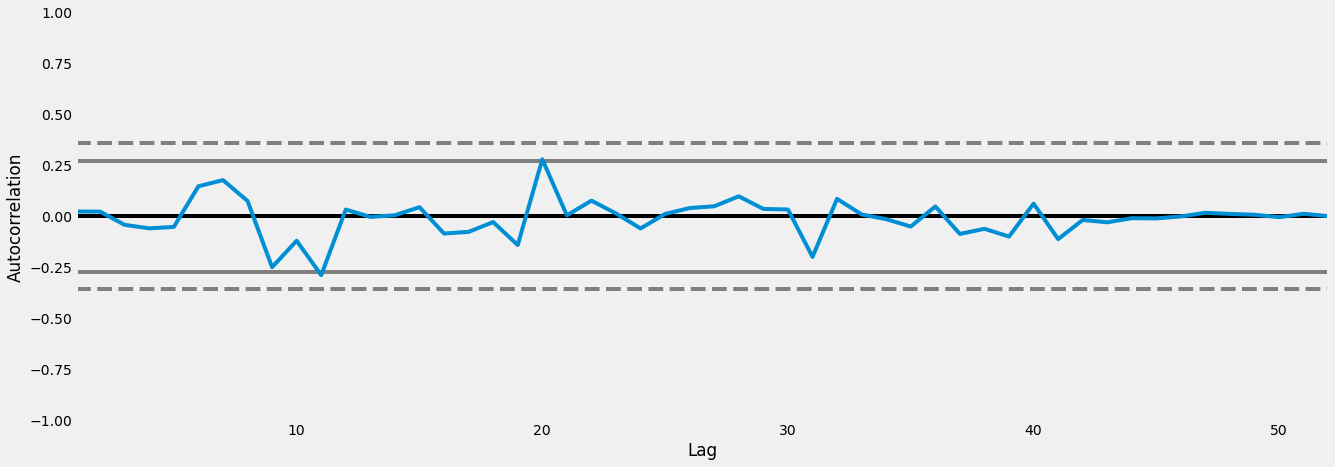

In [272]:
pd.plotting.autocorrelation_plot(bars_df.jma_return)

<AxesSubplot:xlabel='date_time'>

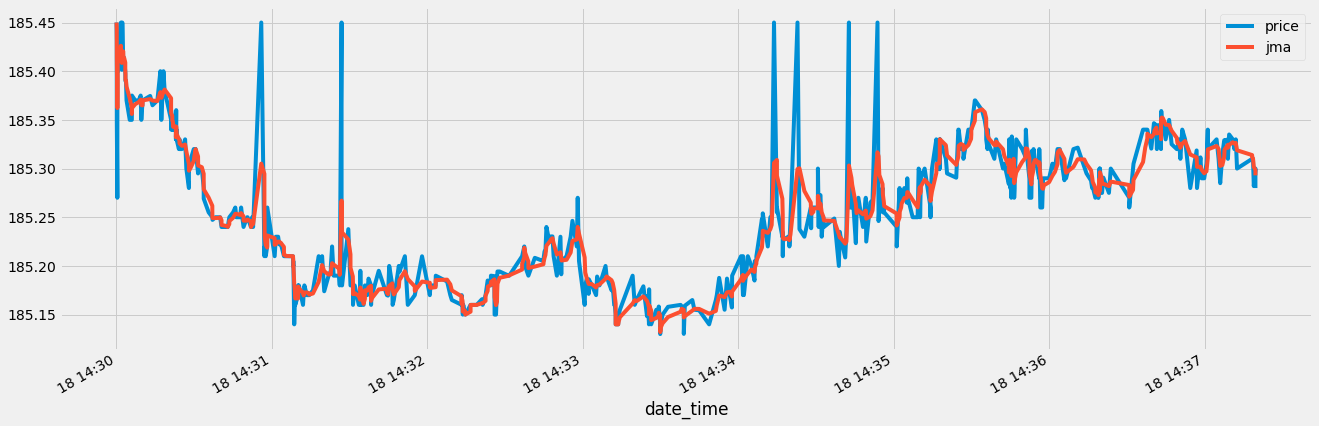

In [273]:
ixs = 0
ixe = ixs+1000
# ixs = 281
# ixe = ixs+200

# ticks2_df[ticks2_df.status=='clean'].loc[ixs:ixe, ['price', 'jma']].plot()
ticks2_df[ticks2_df.status=='clean'].loc[ixs:ixe, ['date_time', 'price', 'jma']].set_index('date_time').plot()

<AxesSubplot:xlabel='date_time'>

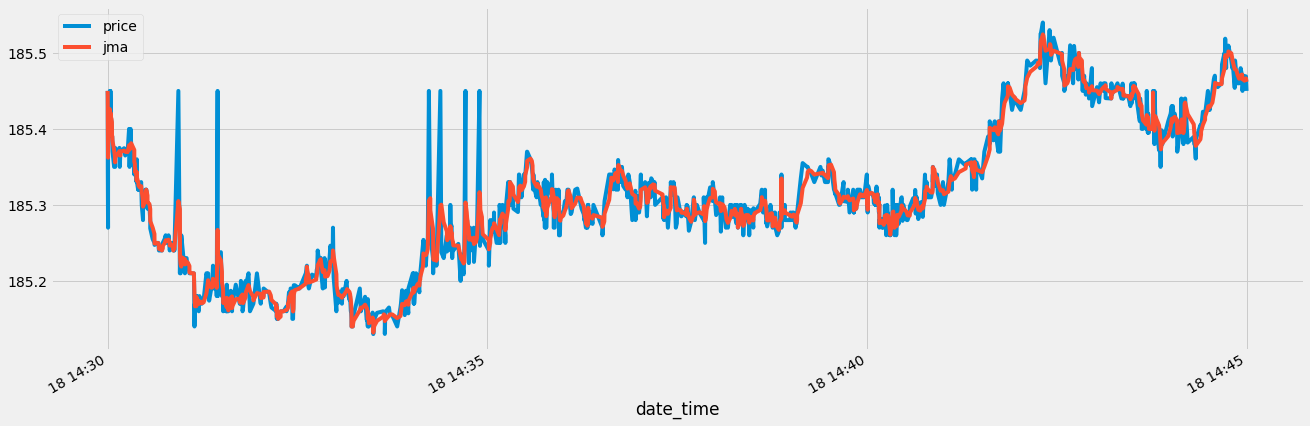

In [286]:


ticks2_df[ticks2_df.status=='clean'].set_index('date_time').between_time('14:25:00', '14:45:00')[['price', 'jma']].plot()
# .plot_bokeh(sizing_mode="scale_height")

# Label Bars

In [306]:
from polygon_s3 import fetch_date_df
from polygon_ds import get_dates_df

# label bars
labeled_bars = bl.label_bars(
    bars=bars,
    ticks_df=ticks2_df,
    risk_level=renko_size*1,
    horizon_mins=30,
    reward_ratios=list(np.arange(2, 20, 1))
    )

labeled_bars_df = pd.DataFrame(labeled_bars)

labeled_bars_df.label_outcome.value_counts() / labeled_bars_df.shape[0]

profit    0.634615
neutral   0.365385
Name: label_outcome, dtype: float64

In [307]:
(labeled_bars_df.label_outcome_at - labeled_bars_df.close_at).describe(percentiles=[.8, .95])

count                           52
mean     0 days 00:15:19.650180445
std      0 days 00:09:42.011844736
min      0 days 00:01:17.666557184
50%      0 days 00:15:10.682587008
80%      0 days 00:28:04.587011788
95%                0 days 00:30:00
max                0 days 00:30:00
dtype: object

In [ ]:
labeled_bars_df.label_rrr.hist(bins=30)

<AxesSubplot:xlabel='date_time'>

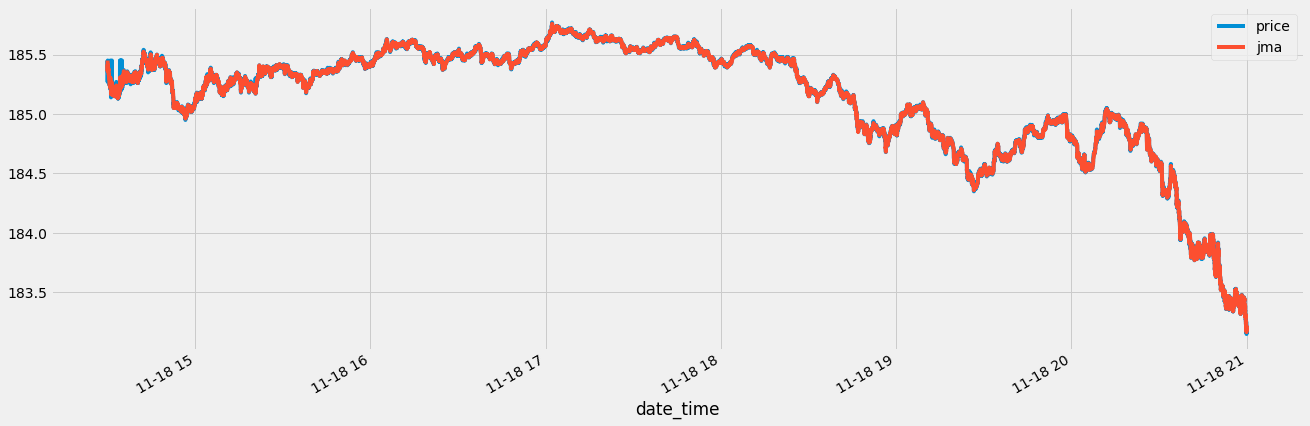

In [302]:
# ticks2_df.loc[:, ['price', 'jma']].plot()
# ticks2_df[ticks2_df.status=='clean'].loc[:, ['price', 'jma']].plot()
ticks2_df[ticks2_df.status=='clean'].set_index('date_time').loc[:, ['price', 'jma']].plot()

<AxesSubplot:>

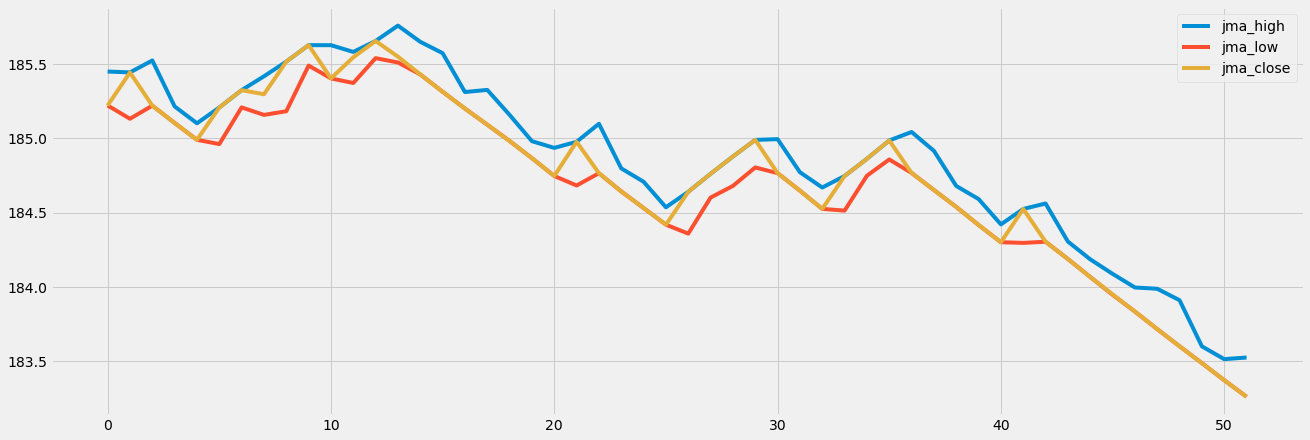

In [303]:
# labeled_bars_df[['jma_wq10', 'jma_wq90']].plot()
labeled_bars_df[['jma_high', 'jma_low','jma_close']].plot()
# labeled_bars_df.set_index('close_at')[['jma_high','jma_low', 'jma_close']].plot()

<AxesSubplot:>

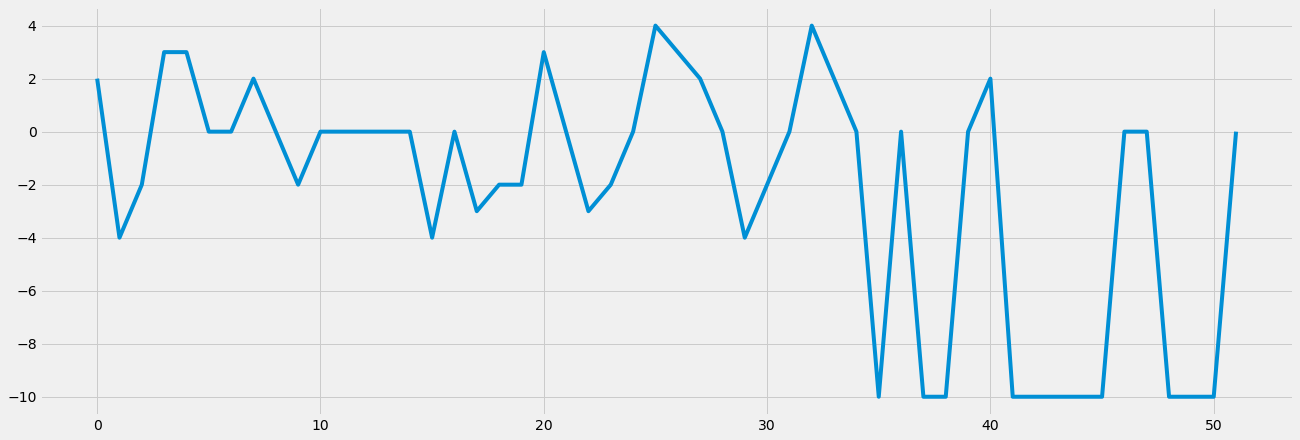

In [304]:
labeled_bars_df['label_rrr'].plot()
# labeled_bars_df.set_index('close_at')['label_rrr'].plot()

In [305]:
(labeled_bars_df.label_outcome_at - labeled_bars_df.label_start_at ).describe(percentiles=[.2, .8])

count                           52
mean     0 days 00:15:06.697578806
std      0 days 00:09:30.061139075
min      0 days 00:01:17.666557184
20%      0 days 00:06:24.647587993
50%      0 days 00:15:10.682587008
80%      0 days 00:23:56.340930918
max                0 days 00:30:00
dtype: object

# Build Bars Workflow

In [ ]:
ray.init(ignore_reinit_error=True, num_cpus=4, dashboard_port=8080)

In [ ]:
daily_bar_stats_df, labeled_bar_dates, stacked_bars_df = bm.bars_workflow_ray(
    symbol, 
    start_date,
    end_date, 
    thresh,
)

In [ ]:
ray.shutdown()